In [435]:
from os import listdir
from os.path import join, isfile
from typing import List

In [436]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data: List[List[int]] = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]

In [437]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [438]:
n_problem = int(input("Elige el problema (1-5): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

In [439]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of vehicles.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [440]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [441]:
toolbox = base.Toolbox()

In [442]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [443]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [444]:
def sort_rides(vehicle_rides):
    def sort_ride(ride):
        a, b, x, y, s, f = ride[1]
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance
    
    return sorted(vehicle_rides, key=lambda ride: sort_ride(ride))

def get_rides_from_ind(individual):
    vehicles_rides = np.full(F, None)
    
    for i, vehicle in enumerate(individual):
        v_r = vehicles_rides[vehicle]
        
        if v_r is None:
            v_r = []
            
        ride = rides[i]
        v_r.append([i, ride])
        
        vehicles_rides[vehicle] = v_r

    return vehicles_rides

def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


In [445]:
def calc_fitness(car_rides):
    fitness = 0
    step = 0
    pos = [0, 0]
    
    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, s, f = ride
        origin = [a, b]
        destiny = [x, y]
        earliest_start = s
        latest_finish = f
        
        # 1.- Go to origin.
        step += dis(pos, origin)
        
        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
          fitness += B
          step = earliest_start
          
        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des
        
        #4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
          fitness += dis_ori_des
          
        # 5.- Update position.
        pos = destiny
                  
        # 6.- Check if reached max distance with one vehicle.
        if step > T:
          break
    
    return fitness
        
def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0

    for car_rides in all_rides:
        if car_rides is not None:
            fitness += calc_fitness(car_rides)

    return fitness,


In [446]:
NIND = 30

pop = toolbox.population(n=NIND)
print(f"Population: {pop}")

Population: [[78, 61, 71, 37, 47, 99, 79, 81, 39, 21, 8, 76, 90, 81, 63, 7, 85, 28, 38, 61, 35, 82, 48, 80, 11, 55, 12, 90, 39, 3, 43, 23, 64, 23, 95, 90, 49, 59, 76, 96, 79, 93, 4, 98, 68, 88, 77, 60, 13, 42, 72, 3, 64, 13, 73, 53, 89, 81, 62, 9, 71, 18, 27, 50, 29, 67, 24, 80, 63, 42, 52, 18, 18, 49, 49, 44, 57, 38, 9, 50, 90, 14, 21, 87, 39, 27, 91, 47, 89, 15, 8, 35, 89, 94, 8, 46, 31, 27, 14, 82, 83, 84, 32, 94, 71, 61, 32, 82, 45, 78, 79, 44, 33, 0, 56, 11, 72, 73, 47, 2, 9, 25, 39, 72, 55, 75, 13, 84, 90, 16, 7, 18, 15, 13, 17, 17, 14, 2, 67, 72, 65, 96, 61, 27, 32, 2, 89, 28, 39, 73, 83, 16, 31, 91, 47, 38, 39, 55, 73, 65, 38, 99, 42, 92, 29, 55, 74, 42, 53, 58, 58, 26, 91, 0, 71, 21, 85, 33, 71, 36, 72, 12, 90, 92, 26, 69, 65, 31, 53, 53, 61, 36, 45, 9, 13, 56, 48, 85, 45, 70, 47, 96, 25, 90, 66, 53, 49, 37, 1, 2, 29, 19, 77, 19, 70, 98, 93, 63, 67, 79, 11, 55, 30, 61, 91, 94, 28, 24, 82, 55, 91, 26, 51, 88, 77, 14, 14, 31, 70, 46, 50, 67, 53, 34, 52, 94, 19, 63, 65, 49, 65, 6

In [447]:
ind = toolbox.individual()

print("Individuo ANTES de evaluar")
print(ind)
print(ind.fitness.valid)
print("\n")

ind.fitness.values = eval_ind(ind)

print("Individuo TRAS evaluar")
print(ind)
print(ind.fitness.valid)
print(ind.fitness)

Individuo ANTES de evaluar
[78, 90, 55, 97, 43, 35, 73, 72, 6, 37, 9, 82, 98, 94, 4, 29, 88, 81, 36, 80, 2, 69, 83, 9, 75, 90, 19, 21, 64, 79, 63, 28, 29, 0, 32, 81, 72, 81, 38, 16, 51, 8, 1, 23, 50, 8, 96, 69, 32, 84, 77, 92, 73, 81, 49, 91, 17, 88, 3, 15, 63, 3, 60, 15, 58, 15, 99, 24, 42, 0, 7, 80, 26, 36, 26, 60, 76, 8, 27, 66, 92, 29, 13, 83, 8, 88, 45, 8, 39, 93, 7, 10, 62, 14, 7, 12, 44, 71, 67, 18, 88, 57, 78, 88, 20, 21, 31, 10, 40, 69, 96, 0, 21, 69, 88, 42, 62, 63, 29, 26, 87, 87, 6, 27, 76, 57, 53, 18, 30, 83, 0, 46, 61, 50, 18, 75, 92, 65, 17, 96, 30, 23, 30, 47, 87, 13, 85, 81, 6, 67, 8, 91, 14, 97, 22, 39, 51, 83, 65, 6, 46, 4, 89, 83, 77, 26, 25, 71, 47, 23, 71, 95, 48, 24, 45, 90, 22, 39, 60, 37, 95, 4, 90, 38, 27, 23, 52, 12, 10, 46, 80, 25, 69, 79, 60, 79, 28, 64, 29, 56, 65, 79, 43, 7, 89, 45, 94, 55, 90, 18, 46, 59, 1, 26, 70, 75, 29, 29, 70, 97, 83, 18, 90, 58, 23, 43, 9, 2, 99, 5, 93, 63, 19, 60, 6, 6, 46, 81, 8, 81, 73, 56, 46, 6, 63, 60, 84, 68, 87, 71, 47, 1, 

In [448]:
TOURNSIZE, INDPB = 3, 0.0

toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=INDPB)
toolbox.register("evaluate", eval_ind)

In [449]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [450]:
CXPB, MUTPB, NGEN = 0., 0., 20

pop, logbook = algorithms.eaSimple(
    pop, toolbox, CXPB, MUTPB, NGEN, stats, verbose=False)

best_sol = tools.selBest(pop, 1)[0]

print(f"El resultado de la evolución es:")
print(logbook)
print(f"La mejor solucion encontrada es: {best_sol}")


El resultado de la evolución es:
gen	nevals	avg   	std    	min   	max   
0  	30    	164150	2701.86	158739	169197
1  	0     	165653	2325.91	160554	169197
2  	0     	167169	1805.57	161973	169197
3  	0     	168589	866.412	166129	169197
4  	0     	169121	100.234	168989	169197
5  	0     	169190	37.3371	168989	169197
6  	0     	169197	0      	169197	169197
7  	0     	169197	0      	169197	169197
8  	0     	169197	0      	169197	169197
9  	0     	169197	0      	169197	169197
10 	0     	169197	0      	169197	169197
11 	0     	169197	0      	169197	169197
12 	0     	169197	0      	169197	169197
13 	0     	169197	0      	169197	169197
14 	0     	169197	0      	169197	169197
15 	0     	169197	0      	169197	169197
16 	0     	169197	0      	169197	169197
17 	0     	169197	0      	169197	169197
18 	0     	169197	0      	169197	169197
19 	0     	169197	0      	169197	169197
20 	0     	169197	0      	169197	169197
La mejor solucion encontrada es: [87, 37, 99, 46, 35, 41, 32, 37, 28, 34, 29, 26, 49, 5

[]

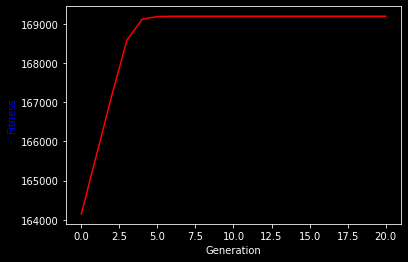

In [451]:
gen = logbook.select("gen")
avgs = logbook.select("avg")

fig = plt.figure()

ax = plt.gca()
line = ax.plot(gen, avgs, "r-", label="Average Fitness")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness", color="b")

plt.plot()

In [452]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

vehicles_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in vehicles_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")